# Week 4: Fourier transform: filtering and sampling

The exercise of this week is about Fourier Transform, image filtering and sampling. First load the following libraries that will be necessary.

In [1]:
!pip install scipy
!pip install scikit-image

In [41]:
%matplotlib inline

from time import time
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from scipy.ndimage import convolve
from scipy.fftpack import fft2, ifft2, fftshift
from matplotlib.pyplot import imshow, show, figure
import numpy as np

In [30]:

def imshow_multi(images, figsize=None, rows=None, cols=None, cmap=None):
	if rows == None: rows = 1
	if cols == None: cols = len(images) // rows + 1
	fig = figure(figsize=figsize)
	for i in range(1, len(images) + 1):
		fig.add_subplot(rows, cols, i)
		imshow(images[i - 1], cmap=cmap)
	show()

Load the two images wall.jpg and sidewalk.jpg.

/tmp/ipykernel_49548/1078355470.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  wall = np.array(imread('wall.jpg'), dtype=np.float) / 255.


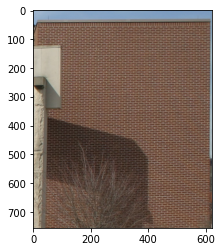

In [3]:
wall = np.array(imread('wall.jpg'), dtype=np.float) / 255.
wall_gray = rgb2gray(wall)
imshow(wall)

/tmp/ipykernel_49548/1910666496.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  side = np.array(imread('sidewalk.jpg'), dtype=np.float) / 255.


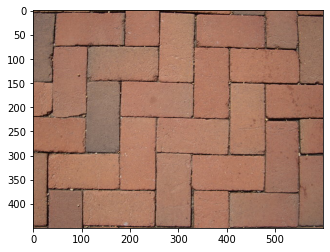

In [4]:
side = np.array(imread('sidewalk.jpg'), dtype=np.float) / 255.
side_gray = rgb2gray(side)
imshow(side)

Preliminary question: which of the two images has the most low pass content? Which one has the most high pass content?

Answer:

The first image has more low-pass content, as there are more "objects" in it that don't resemble the rest of the image. E.g. the shadow, tree or sky. The second image mostly has repeating content (brick pattern) but no other "large" features.

The following functions will be useful in the course of this tutorial: *fft2*, *ifft2*, *convolve* from scipy and the following function:

float64


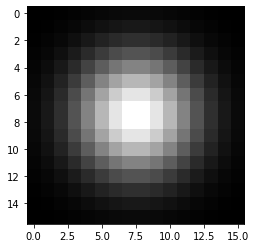

In [10]:
def gaussian_filter(shape, sigma):
    """
    Returns a 2D gaussian filter specified by its shape and standard deviation.
    """
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

print(example_gaussian.dtype)

example_gaussian = gaussian_filter((16, 16), 3)
imshow(example_gaussian, cmap='gray')

## Part A: Filtering

Create three Gaussian filters:
- one 5x5 Gaussian low pass filter with standard deviation 1
- one 15x15 Gaussian high pass filter with standard deviation 3.5. Hint: the high pass content of an image can be extracted by subtracting the low pass filtered image from the original image. Hence, you can get a high pass filter kernel from a low pass one by subtracting the low pass filter kernel from a unit impulse filter. A unit impulse filter is a filter full of 0s with a single 1 in the middle, that once convolved with an image returns the same image.
- one band pass filter. To do this, create first a 15x15 Gaussian filter with standard deviation 1 and then convolve this low pass filter with the previous high pass filter to create the band pass filter. Indeed, convolution is associative: img * band_pass = (img * low_pass) * high_pass = img * (low_pass * high_pass).

You can then visualize your filters in spatial and frequency domains (using *fft2* and *fftshift* from scipy for the latter). Since the filters are complex in the frequency domain, use *np.abs()* to display the magnitude of the filter.

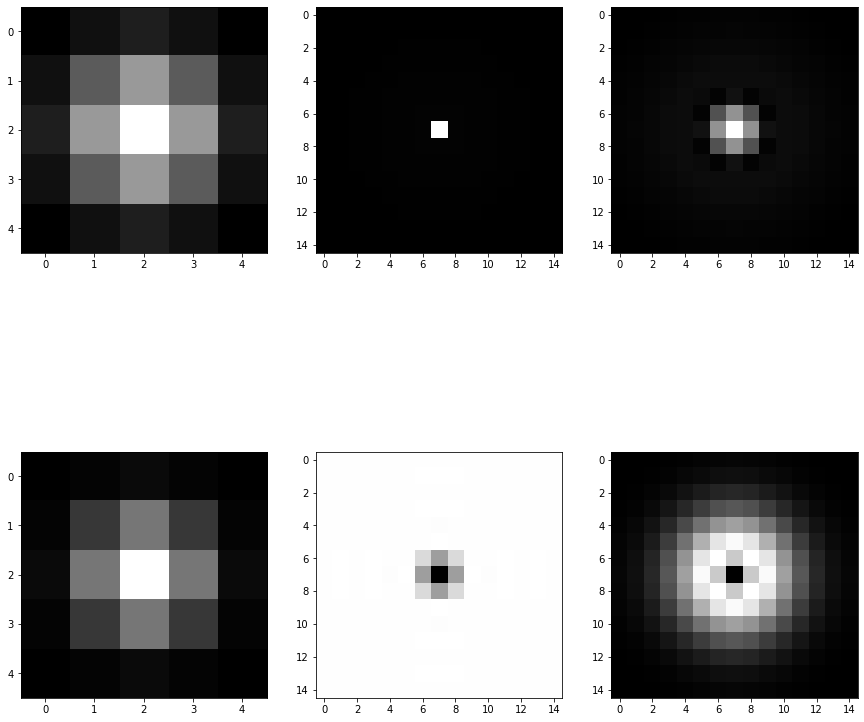

In [35]:
def unit_filter(shape):
    filter = np.zeros(shape)
    filter[shape[0] // 2, shape[1] // 2] = 1.
    return filter


k_gauss_5 = gaussian_filter((5, 5), 1)
k_gauss_15 = gaussian_filter((15, 15), 3.5)
k_gauss_15_1 = gaussian_filter((15, 15), 1)
k_unit_15 = unit_filter((15, 15))

# Low pass filter
k_low_pass = k_gauss_5
k_low_pass_freq = fftshift(fft2(k_low_pass))

# High pass filter
k_high_pass = k_unit_15 - k_gauss_15
k_high_pass_freq = fftshift(fft2(k_high_pass))

# Band pass filter
k_band_pass = convolve(k_gauss_15_1, k_high_pass)
k_band_pass_freq = fftshift(fft2(k_band_pass))

# Visualize filters
imshow_multi(
    list(map(
        lambda x: np.abs(x),
        [
            k_low_pass,
            k_high_pass,
            k_band_pass,
            k_low_pass_freq,
            k_high_pass_freq,
            k_band_pass_freq
        ]
    )),
    (15, 15),
    2, 3,
    'gray'
)


Apply these three filters to the two sample grayscale images in spatial domain first by convolving the image with the kernel, and in frequency domain secondly by taking the Fourier tranform of both the image and the filter kernel and multiplying them. Compare the runtimes of spatial and frequency domain filtering, using the *time* function of python. Compare the filtering results of two images by visualizing the filtered images in both spatial and frequency domains. Check that your initial guess about the low/high pass content of the images is correct.

### Filtering in spatial domain

In [64]:
def time_func(f, *args):
    start = time()
    res = f(args)
    end = time()
    dur = end - start
    print(f"Function {f} completed in {dur} seconds")
    return res


def apply_all_filters(img, name, filters, time=False):
    print("Original image:")
    imshow(img, cmap='gray')
    show()

    # Enter your code here
    print("Filtered images:")

    images = {}

    for fname, ffunc in filters.items():
        res = None
        if time:
            res = time_func(ffunc, img)
        else:
            res = ffunc(img)
        images[f'{name}__{fname}'] = res

    for (name, img) in images.items():
        imsave(f'./out/{name}.bmp', img)

    imshow_multi(list(images.values()), figsize=(15, 15), cmap='gray')


Original image:


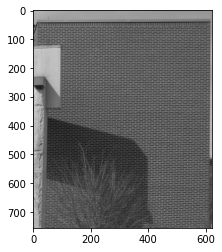

Filtered images:


RuntimeError: filter weights array has incorrect shape.

In [65]:
filters = {
	'lpf': lambda img: convolve(img, k_low_pass),
	'hpf': lambda img: convolve(img, k_high_pass),
	'bpf': lambda img: convolve(img, k_band_pass)
}

apply_all_filters(wall_gray, 'wall_gray', filters, True)

Original image:


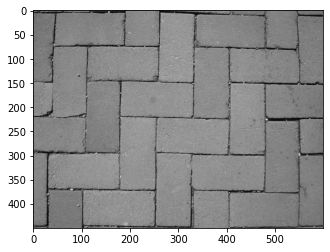

Filtered images:


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.4448717317218027, 0.5852745609170856]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.27103391978997315, 0.3249678295302928]. Convert image to uint8 prior to saving to suppress this warning.


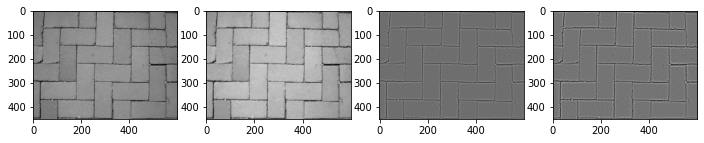

In [55]:
filter_image_domain(side_gray, 'side_gray')

### Filtering in frequency domain

Note: the output of *ifft2* is a numpy array with complex values. You can use the command *.astype(float)* to convert it back to real numbers.

In [ ]:
print("Original image:")
imshow(wall_gray, cmap='gray')
show()

# Enter your code here

In [ ]:
print("Original image:")
imshow(side_gray, cmap='gray')
show()

# Enter your code here

## Part B: Sampling

Downsample both images to one fourth of the resolution by taking every second row and column. You can use numpy array slicing for this: *my_array[start:end:step]*. Compare the results in terms of distortions and unexpected effects. Explain why the quality of the two downsampled images differ. 

In [ ]:
# Enter your code here

Create three 15x15 Gaussian low pass filters with standard deviations 0.5, 1 and 1.5 and apply them to the color image wall.jpg. You can filter the three channels separately and gather them in an RGB image with the numpy function *np.stack([r_img, g_img, b_img], axis=-1)*. Downsample the three filtered images to one fourth resolution. Compare the resulting downsampled images in terms of quality.

In [ ]:
# Create the filters
# Enter your code here

# Convolve them with the RGB image
# Enter your code here

# Downsample the resulting images
# Enter your code here

## Bonus: for those that finished earlier

Load the blurred road signs image and using your fresh knowledge about filters, design the perfect filter to make the text readable.

In [ ]:
blurred_road_signs = np.array(imread('blurred_road_signs.jpg', as_gray=True), dtype=np.float) / 255.

figure(figsize=(10, 10))
imshow(blurred_road_signs, cmap='gray')
show()